# External Sorting Memory Analysis

This notebook analyzes memory usage patterns for external sorting with separate run generation and merge phases.

## Key Formulas:
- **Run Generation Memory**: `run_size × threads`
- **Merge Memory**: `(D / run_size) × threads × page_size`
- **Constraints**:
  - Max run size (run gen): `run_size ≤ M / T`
  - Min run size (merge): `run_size ≥ D × P × T / M`

In [1]:
# Import all required libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib import cm

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

# Constants
P_KB = 64  # Page size in KB
P_MB = P_KB / 1024  # Page size in MB (0.0625)
MB = 1024 * 1024  # Bytes to MB conversion
GB = 1024 * 1024 * 1024  # Bytes to GB conversion

## 1. Memory Usage Matrices

Visualize how memory usage varies with thread count and run size for both phases.

In [2]:
# Define thread counts and run sizes
thread_counts = [1, 2, 4, 8, 16, 32, 64]
run_sizes_mb = [8, 16, 32, 64, 128, 256, 512, 1024]  # 8MB to 1GB
run_size_labels = ['8MB', '16MB', '32MB', '64MB', '128MB', '256MB', '512MB', '1GB']

# Create memory usage matrices
memory_matrix = np.zeros((len(run_sizes_mb), len(thread_counts)))
for i, run_size in enumerate(run_sizes_mb):
    for j, threads in enumerate(thread_counts):
        memory_matrix[i, j] = run_size * threads

# Flip for display (small sizes at bottom)
memory_matrix_flipped = np.flipud(memory_matrix)
run_size_labels_flipped = list(reversed(run_size_labels))

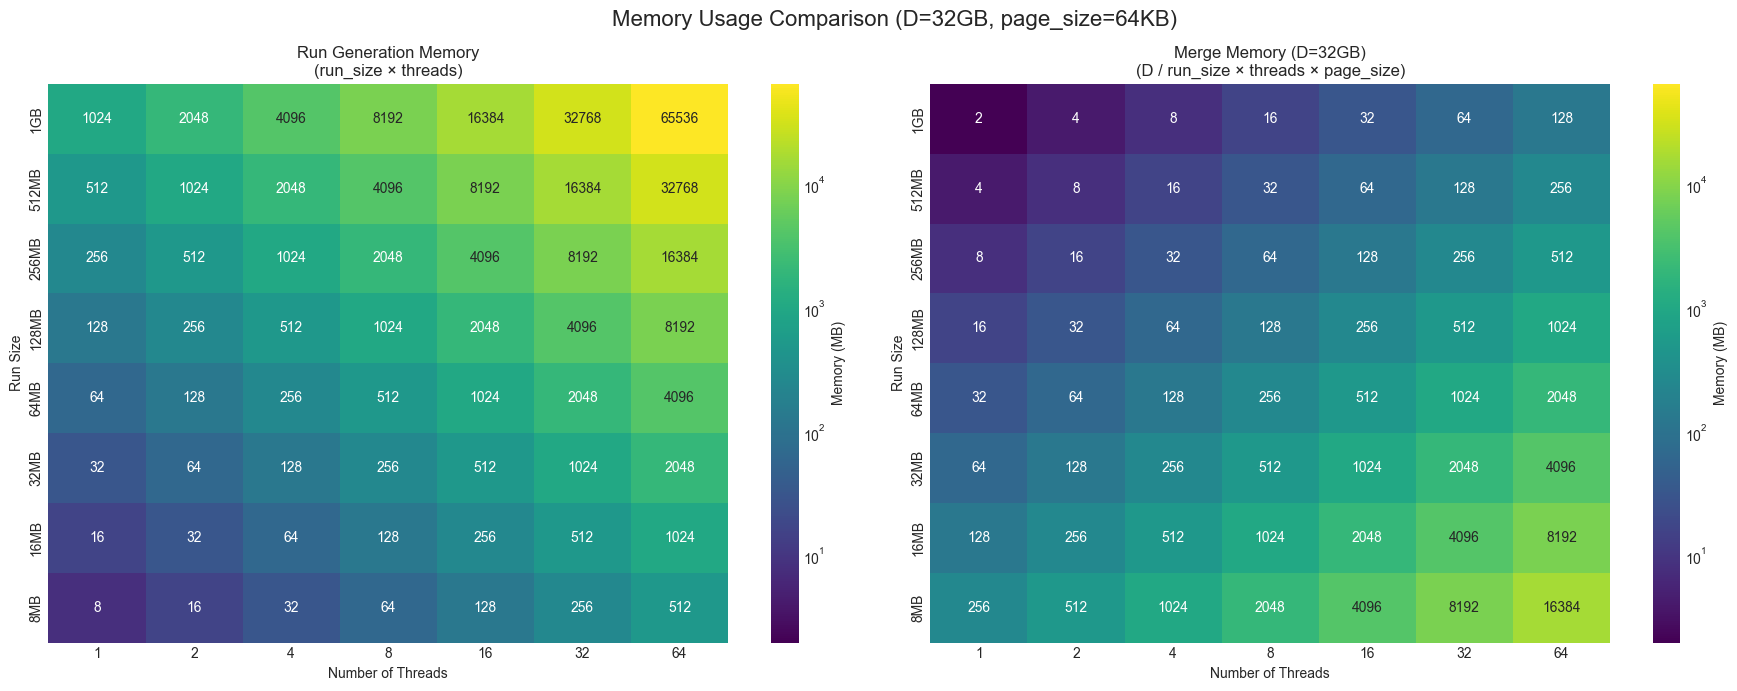


Optimal configuration for D=32GB:
  Run size: 32MB, Threads: 1
  Memory: Run Gen=32MB, Merge=64.0MB, Total=64.0MB


In [3]:
# Interactive memory comparison with adjustable dataset size
def plot_memory_comparison(D_GB=32, machine_memory_mb=None):
    """
    Plot memory usage comparison for run generation and merge phases.
    
    Args:
        D_GB: Dataset size in GB
        machine_memory_mb: Optional memory constraint to highlight
    """
    D_MB = D_GB * 1024
    
    # Calculate merge memory matrix
    merge_memory_matrix = np.zeros((len(run_sizes_mb), len(thread_counts)))
    for i, run_size in enumerate(run_sizes_mb):
        for j, threads in enumerate(thread_counts):
            merge_memory_matrix[i, j] = (D_MB / run_size) * threads * P_MB
    
    # Flip matrices
    merge_memory_flipped = np.flipud(merge_memory_matrix)
    
    # Find global min/max for consistent color scale
    vmin = min(memory_matrix_flipped.min(), merge_memory_flipped.min())
    vmax = max(memory_matrix_flipped.max(), merge_memory_flipped.max())
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # Use log normalization
    norm = colors.LogNorm(vmin=max(vmin, 0.1), vmax=vmax)
    
    # Plot heatmaps
    sns.heatmap(memory_matrix_flipped, annot=True, fmt='.0f', cmap='viridis',
                norm=norm, xticklabels=thread_counts, yticklabels=run_size_labels_flipped,
                cbar_kws={'label': 'Memory (MB)'}, ax=ax1)
    ax1.set_xlabel('Number of Threads')
    ax1.set_ylabel('Run Size')
    ax1.set_title('Run Generation Memory\n(run_size × threads)')
    
    sns.heatmap(merge_memory_flipped, annot=True, fmt='.0f', cmap='viridis',
                norm=norm, xticklabels=thread_counts, yticklabels=run_size_labels_flipped,
                cbar_kws={'label': 'Memory (MB)'}, ax=ax2)
    ax2.set_xlabel('Number of Threads')
    ax2.set_ylabel('Run Size')
    ax2.set_title(f'Merge Memory (D={D_GB}GB)\n(D / run_size × threads × page_size)')
    
    # Add memory constraint lines if specified
    if machine_memory_mb:
        for ax, matrix in [(ax1, memory_matrix), (ax2, merge_memory_matrix)]:
            for i, run_size in enumerate(reversed(run_sizes_mb)):
                max_threads = machine_memory_mb / run_size
                if matrix is merge_memory_matrix:
                    max_threads = machine_memory_mb / ((D_MB / run_size) * P_MB)
                
                # Find boundary position
                for j, t in enumerate(thread_counts):
                    if t > max_threads:
                        if j > 0:
                            x_pos = j - 0.5 + (max_threads - thread_counts[j-1]) / (t - thread_counts[j-1])
                            ax.plot([0, x_pos], [i, i], 'r-', linewidth=3)
                        break
                else:
                    ax.plot([0, len(thread_counts)], [i, i], 'r-', linewidth=3)
    
    plt.suptitle(f'Memory Usage Comparison (D={D_GB}GB, page_size=64KB)', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print optimal configuration
    min_memory = float('inf')
    optimal_config = None
    
    for run_size, label in zip(run_sizes_mb, run_size_labels):
        for threads in thread_counts:
            run_gen_mem = run_size * threads
            merge_mem = (D_MB / run_size) * threads * P_MB
            total_mem = max(run_gen_mem, merge_mem)
            
            if total_mem < min_memory:
                min_memory = total_mem
                optimal_config = (label, threads, run_gen_mem, merge_mem)
    
    if optimal_config:
        label, threads, run_gen, merge = optimal_config
        print(f"\nOptimal configuration for D={D_GB}GB:")
        print(f"  Run size: {label}, Threads: {threads}")
        print(f"  Memory: Run Gen={run_gen:.0f}MB, Merge={merge:.1f}MB, Total={min_memory:.1f}MB")

# Example usage
plot_memory_comparison(D_GB=32)

## 2. Run Size Constraints Visualization

Shows the feasible region between minimum and maximum run size constraints.

In [ ]:
def plot_constraints(M_GB=4, D_GB=32, scale='semilogy'):
    """
    Plot run size constraints for a specific memory and dataset size.
    
    Args:
        M_GB: Total memory in GB
        D_GB: Dataset size in GB
        scale: 'semilogy', 'loglog', or 'linear'
    """
    plt.figure(figsize=(12, 8))
    
    # Thread values
    T_values = np.linspace(1, 128, 500)
    
    # Convert to MB
    M_MB = M_GB * 1024
    D_MB = D_GB * 1024
    
    # Calculate constraints
    max_run_size = M_MB / T_values  # Run gen constraint
    min_run_size = (D_MB * P_MB * T_values) / M_MB  # Merge constraint
    
    # Plot function based on scale
    plot_func = {'semilogy': plt.semilogy, 'loglog': plt.loglog, 'linear': plt.plot}[scale]
    
    # Plot constraints with thick lines
    plot_func(T_values, max_run_size, '--', color='blue', 
              linewidth=4, label=f"Max (Run Gen): M/T", alpha=0.9)
    plot_func(T_values, min_run_size, '-', color='red', 
              linewidth=4, label=f"Min (Merge): D×P×T/M", alpha=0.9)
    
    # Fill feasible region
    feasible_mask = min_run_size <= max_run_size
    if np.any(feasible_mask):
        plt.fill_between(T_values[feasible_mask], 
                        min_run_size[feasible_mask], 
                        max_run_size[feasible_mask],
                        alpha=0.3, color='green', label='Feasible Region')
    
    # Mark crossover point
    T_crossover = M_MB / np.sqrt(D_MB * P_MB)
    RS_crossover = M_MB / T_crossover
    if 1 <= T_crossover <= 128:
        plt.plot(T_crossover, RS_crossover, 'o', color='black', 
                markersize=12, markeredgewidth=2, markeredgecolor='white',
                label=f'Crossover: T={T_crossover:.1f}')
    
    # Formatting
    plt.xlabel('Number of Threads (T)', fontsize=14)
    plt.ylabel('Run Size (MB)' + (' - Log Scale' if 'log' in scale else ''), fontsize=14)
    plt.title(f'Run Size Constraints for M={M_GB}GB, D={D_GB}GB\n' + 
              'Feasible region between max and min constraints', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 130)
    
    if scale == 'semilogy':
        plt.ylim(0.1, 100000)
    elif scale == 'linear':
        plt.ylim(0, max(M_MB, 5000))
    
    # Mark common thread counts with thin lines
    for t in [1, 2, 4, 8, 16, 32, 64, 128]:
        plt.axvline(x=t, color='gray', linestyle=':', alpha=0.3, linewidth=1)
        plt.text(t, plt.ylim()[0] * 1.5, f'{t}', ha='center', fontsize=8, rotation=0)
    
    # Add annotations
    if scale == 'semilogy':
        plt.text(5, M_MB/10, f'M={M_GB}GB', fontsize=12, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5))
        plt.text(100, 10, f'D={D_GB}GB', fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.5))
    
    # Legend with white background and box
    plt.legend(loc='best', fontsize=12, frameon=True, fancybox=True, 
               framealpha=1.0, facecolor='white', edgecolor='black')
    plt.tight_layout()
    plt.show()
    
    # Print analysis
    print(f"\nAnalysis for M={M_GB}GB, D={D_GB}GB:")
    print("="*50)
    print(f"Maximum feasible threads: {T_crossover:.1f}")
    print(f"Optimal run size at crossover: {RS_crossover:.0f}MB")
    print(f"Practical recommendation: Use {min(int(T_crossover), 32)} threads or fewer")
    
    # Find feasible range for common thread counts
    print(f"\nFeasible run size ranges:")
    for t in [1, 2, 4, 8, 16, 32]:
        if t <= T_crossover:
            max_rs = M_MB / t
            min_rs = (D_MB * P_MB * t) / M_MB
            print(f"  {t:2d} threads: {min_rs:6.1f} - {max_rs:6.0f} MB")
        else:
            print(f"  {t:2d} threads: No feasible run size")


def plot_multiple_constraints(configs, scale='semilogy', policy_thread=32, policy_config_idx=0, t_max=128):
    """
    Plot multiple configurations on the same graph for comparison with policy lines.
    
    Args:
        configs: List of dicts with 'M_GB', 'D_GB', 'color', 'label' keys
        scale: 'semilogy', 'loglog', or 'linear'
        policy_thread: Thread count to use for policies 2 and 3
        policy_config_idx: Index of configuration to use for policy lines
        t_max: Maximum thread count cap for policy 5
    """
    plt.figure(figsize=(14, 10))
    
    # Thread values
    T_values = np.linspace(1, 128, 500)
    
    # Plot function based on scale
    plot_func = {'semilogy': plt.semilogy, 'loglog': plt.loglog, 'linear': plt.plot}[scale]
    
    # Track policy values
    policy_values = {}
    
    for idx, config in enumerate(configs):
        M_MB = config['M_GB'] * 1024
        D_MB = config['D_GB'] * 1024
        
        # Constraints - make these lines thick
        max_run_size = M_MB / T_values  # Run gen constraint
        min_run_size = (D_MB * P_MB * T_values) / M_MB  # Merge constraint
        
        # Plot with thick lines
        plot_func(T_values, max_run_size, '--', color='r', 
                  linewidth=4, label=f"{config['label']} (Run Gen)", alpha=0.9)
        plot_func(T_values, min_run_size, '-', color='b', 
                  linewidth=4, label=f"{config['label']} (Merge)", alpha=0.9)
        
        # Calculate policy values for the specified config
        if idx == policy_config_idx:
            # Policy 1: min at T=1
            policy_values['policy1'] = (D_MB * P_MB * 1) / M_MB
            # Policy 2: max at policy_thread
            policy_values['policy2'] = M_MB / policy_thread
            # Policy 3: min at policy_thread
            policy_values['policy3'] = (D_MB * P_MB * policy_thread) / M_MB
            # Policy 4: max at T=1
            policy_values['policy4'] = M_MB / 1
            # Policy 5: RunSizeAtIntersection
            t_crossover = M_MB / np.sqrt(D_MB * P_MB)
            t_policy5 = min(t_crossover, t_max)
            policy_values['policy5'] = M_MB / t_policy5
            policy_values['t_policy5'] = t_policy5
    
    # Add vertical line at policy_thread - make it thinner
    plt.axvline(x=policy_thread, color='black', linewidth=1.5, linestyle='-', alpha=0.4,
                label=f'T = {policy_thread}')
    
    # Add policy horizontal lines - make them thinner
    if policy_values:
        # Policy 1: TinyRuns_MaxParallelGen_SerialMerge
        plt.axhline(y=policy_values['policy1'], color='purple', linewidth=1.5, 
                   linestyle='-.', alpha=0.6, label=f"TinyRuns_MaxParallelGen_SerialMerge: {policy_values['policy1']:.1f}MB")
        
        # Policy 2: GenBoundRuns_MaxParallelGen_LimitedParallelMerge
        plt.axhline(y=policy_values['policy2'], color='darkred', linewidth=1.5, 
                   linestyle='-.', alpha=0.6, label=f"GenBoundRuns_MaxParallelGen_LimitedParallelMerge(T={policy_thread}): {policy_values['policy2']:.0f}MB")
        
        # Policy 3: MergeBoundRuns_LimitedParallelGen_MaxParallelMerge
        plt.axhline(y=policy_values['policy3'], color='darkgreen', linewidth=1.5, 
                   linestyle='-.', alpha=0.6, label=f"MergeBoundRuns_LimitedParallelGen_MaxParallelMerge(T={policy_thread}): {policy_values['policy3']:.1f}MB")
        
        # Policy 4: HugeRuns_SerialGen_MaxParallelMerge
        plt.axhline(y=policy_values['policy4'], color='orange', linewidth=1.5, 
                   linestyle='-.', alpha=0.6, label=f"HugeRuns_SerialGen_MaxParallelMerge: {policy_values['policy4']:.0f}MB")
        
        # Policy 5: MediumRuns_BalancedParallelism
        plt.axhline(y=policy_values['policy5'], color='cyan', linewidth=2.5, 
                   linestyle='--', alpha=0.8, label=f"MediumRuns_BalancedParallelism(T={policy_values['t_policy5']:.1f}): {policy_values['policy5']:.0f}MB")
        
        # Add vertical line at the crossover T for policy 5
        plt.axvline(x=policy_values['t_policy5'], color='cyan', linewidth=1.5, linestyle=':', alpha=0.6,
                    label=f'T_crossover = {policy_values["t_policy5"]:.1f}')

    # Formatting
    plt.xlabel('Number of Threads (T)', fontsize=14)
    plt.ylabel('Run Size (MB)' + (' - Log Scale' if 'log' in scale else ''), fontsize=14)
    plt.title('Run Size Constraints Comparison with Policy Lines\n' + 
              'Max (Run Gen): RS ≤ M/T  |  Min (Merge): RS ≥ D×P×T/M', fontsize=16)
    plt.grid(True, alpha=0.2)
    plt.xlim(0, 40)
    
    if scale == 'semilogy':
        plt.ylim(0.1, 100000)
    elif scale == 'linear':
        plt.ylim(0, 5000)
    
    # Mark common thread counts with very thin lines
    for t in [1, 2, 4, 8, 16, 32, 64, 128]:
        if t != policy_thread and t != policy_values.get('t_policy5', -1):
            plt.axvline(x=t, color='gray', linestyle=':', alpha=0.2, linewidth=0.8)
    
    # Legend with white background and box
    plt.legend(loc='best', fontsize=10, ncol=1, frameon=True, fancybox=True,
               framealpha=1.0, facecolor='white', edgecolor='black')
    
    plt.tight_layout()
    plt.show()
    
    # Print analysis
    print("\nCrossover Analysis (where constraints meet):")
    print("="*60)
    print(f"{'Config':<25} {'Max Threads':<15} {'Crossover RS (MB)':<15}")
    print("-"*60)
    
    for config in configs:
        M_MB = config['M_GB'] * 1024
        D_MB = config['D_GB'] * 1024
        T_max_config = M_MB / np.sqrt(D_MB * P_MB)
        RS_cross = np.sqrt(M_MB * D_MB * P_MB)
        print(f"{config['label']:<25} {T_max_config:<15.1f} {RS_cross:<15.0f}")
    
    # Print policy definitions
    if policy_values:
        print(f"\nPolicy Lines (based on {configs[policy_config_idx]['label']}):")
        print("="*60)
        print(f"Policy 1 (TinyRuns_MaxParallelGen_SerialMerge): {policy_values['policy1']:.1f} MB")
        print(f"Policy 2 (GenBoundRuns_MaxParallelGen_LimitedParallelMerge): {policy_values['policy2']:.0f} MB")
        print(f"Policy 3 (MergeBoundRuns_LimitedParallelGen_MaxParallelMerge): {policy_values['policy3']:.1f} MB")
        print(f"Policy 4 (HugeRuns_SerialGen_MaxParallelMerge): {policy_values['policy4']:.0f} MB")
        print(f"Policy 5 (MediumRuns_BalancedParallelism): {policy_values['policy5']:.0f} MB")


# Example usage: Single configuration
plot_constraints(M_GB=4, D_GB=32)

# Example usage: Multiple configurations with policy lines
configs = [
    {'M_GB': 1, 'D_GB': 32, 'color': 'blue', 'label': 'M=1GB, D=32GB'},
]
plot_multiple_constraints(configs, policy_thread=32, policy_config_idx=0)

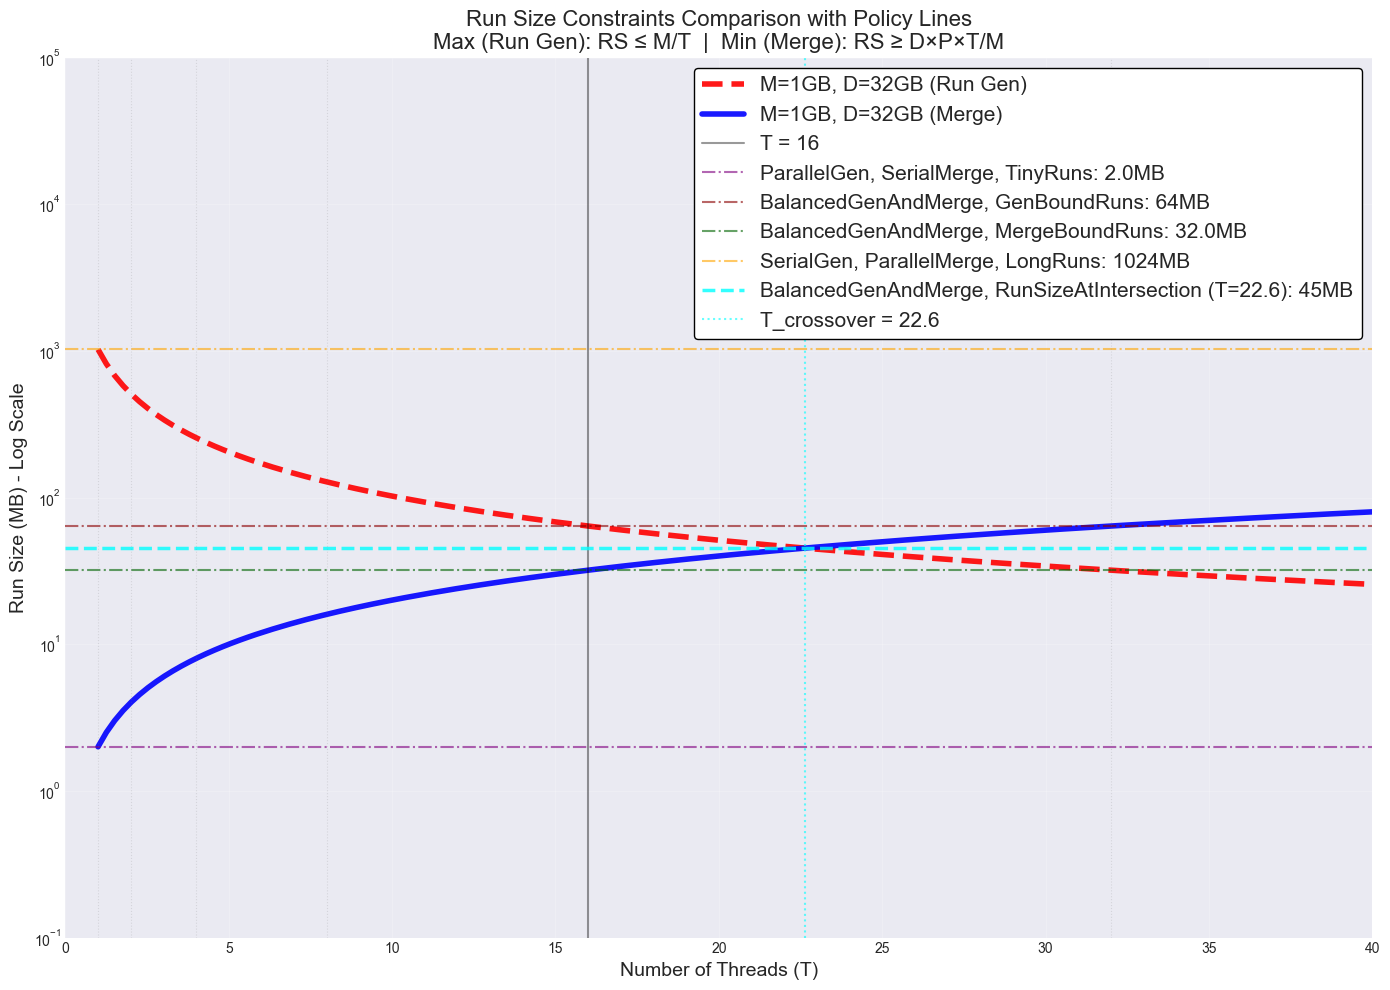


Crossover Analysis (where constraints meet):
Config                    Max Threads     Crossover RS (MB)
------------------------------------------------------------
M=1GB, D=32GB             22.6            1448           

Policy Lines (based on M=1GB, D=32GB):
Policy 1: Min constraint at T=1     = 2.0 MB
Policy 2: Max constraint at T=16    = 64 MB
Policy 3: Min constraint at T=16    = 32.0 MB
Policy 4: Max constraint at T=1     = 1024 MB
Policy 5: Run size at crossover (T=22.6) = 45 MB


In [5]:
# Example usage: Multiple configurations with policy lines
configs = [
    {'M_GB': 1, 'D_GB': 32, 'color': 'blue', 'label': 'M=1GB, D=32GB'},
]

plot_multiple_constraints(configs, policy_thread=16, policy_config_idx=0)

## 3. Policy Analysis: Computing Run Generation Threads, Merge Threads, and Run Sizes

This section demonstrates how to calculate the run generation thread count, merge thread count, and run size for each of the four policies:

- **Policy 1**: Minimize run size (use minimum constraint at T=1)
- **Policy 2**: Maximize run size with fixed threads (use maximum constraint at chosen T)
- **Policy 3**: Minimize run size with fixed threads (use minimum constraint at chosen T)
- **Policy 4**: Maximize run size (use maximum constraint at T=1)

In [ ]:
def compute_policy_parameters(M_GB, D_GB, fixed_threads=32, t_max=128):
    """
    Compute run generation threads, merge threads, and run size for each policy.
    
    Args:
        M_GB: Total memory in GB
        D_GB: Dataset size in GB
        fixed_threads: Thread count for policies 2 and 3
        t_max: Maximum thread count cap for policy 5
    
    Returns:
        Dictionary with parameters for each policy
    """
    # Convert to MB
    M_MB = M_GB * 1024
    D_MB = D_GB * 1024
    
    results = {}
    
    # Policy 1: TinyRuns_MaxParallelGen_SerialMerge
    # Run size = D × P × T / M where T=1
    run_size_1 = (D_MB * P_MB * 1) / M_MB
    run_gen_threads_1 = M_MB / run_size_1  # Maximum threads that fit in memory
    merge_threads_1 = M_MB / ((D_MB / run_size_1) * P_MB)  # Maximum threads for merge
    
    results['policy1'] = {
        'name': 'TinyRuns_MaxParallelGen_SerialMerge',
        'run_size_mb': run_size_1,
        'run_gen_threads': run_gen_threads_1,
        'merge_threads': merge_threads_1,
        'run_gen_memory': run_size_1 * run_gen_threads_1,
        'merge_memory': (D_MB / run_size_1) * merge_threads_1 * P_MB
    }
    
    # Policy 2: GenBoundRuns_MaxParallelGen_LimitedParallelMerge
    # Run size = M / T where T=fixed_threads
    run_size_2 = M_MB / fixed_threads
    run_gen_threads_2 = fixed_threads
    merge_threads_2 = M_MB / ((D_MB / run_size_2) * P_MB)
    
    results['policy2'] = {
        'name': f'GenBoundRuns_MaxParallelGen_LimitedParallelMerge(T={fixed_threads})',
        'run_size_mb': run_size_2,
        'run_gen_threads': run_gen_threads_2,
        'merge_threads': merge_threads_2,
        'run_gen_memory': run_size_2 * run_gen_threads_2,
        'merge_memory': (D_MB / run_size_2) * merge_threads_2 * P_MB
    }
    
    # Policy 3: MergeBoundRuns_LimitedParallelGen_MaxParallelMerge
    # Run size = D × P × T / M where T=fixed_threads
    run_size_3 = (D_MB * P_MB * fixed_threads) / M_MB
    run_gen_threads_3 = M_MB / run_size_3
    merge_threads_3 = fixed_threads
    
    results['policy3'] = {
        'name': f'MergeBoundRuns_LimitedParallelGen_MaxParallelMerge(T={fixed_threads})',
        'run_size_mb': run_size_3,
        'run_gen_threads': run_gen_threads_3,
        'merge_threads': merge_threads_3,
        'run_gen_memory': run_size_3 * run_gen_threads_3,
        'merge_memory': (D_MB / run_size_3) * merge_threads_3 * P_MB
    }
    
    # Policy 4: HugeRuns_SerialGen_MaxParallelMerge
    # Run size = M / T where T=1
    run_size_4 = M_MB / 1
    run_gen_threads_4 = 1
    merge_threads_4 = M_MB / ((D_MB / run_size_4) * P_MB)
    
    results['policy4'] = {
        'name': 'HugeRuns_SerialGen_MaxParallelMerge',
        'run_size_mb': run_size_4,
        'run_gen_threads': run_gen_threads_4,
        'merge_threads': merge_threads_4,
        'run_gen_memory': run_size_4 * run_gen_threads_4,
        'merge_memory': (D_MB / run_size_4) * merge_threads_4 * P_MB
    }
    
    # Policy 5: MediumRuns_BalancedParallelism
    # T = min(M/sqrt(D*P), t_max)
    # Run size = M / T
    t_crossover = M_MB / np.sqrt(D_MB * P_MB)
    t_policy5 = min(t_crossover, t_max)
    run_size_5 = M_MB / t_policy5
    run_gen_threads_5 = t_policy5
    merge_threads_5 = t_policy5
    
    results['policy5'] = {
        'name': f'MediumRuns_BalancedParallelism(T={t_policy5:.1f})',
        'run_size_mb': run_size_5,
        'run_gen_threads': run_gen_threads_5,
        'merge_threads': merge_threads_5,
        'run_gen_memory': run_size_5 * run_gen_threads_5,
        'merge_memory': (D_MB / run_size_5) * merge_threads_5 * P_MB
    }
    
    return results


def display_policy_comparison(M_GB, D_GB, fixed_threads=32, t_max=128):
    """
    Display a comprehensive comparison of all policies.
    """
    results = compute_policy_parameters(M_GB, D_GB, fixed_threads, t_max)
    
    print(f"Policy Comparison for M={M_GB}GB, D={D_GB}GB, Fixed T={fixed_threads}, T_max={t_max}")
    print("="*110)
    print(f"{'Policy':<55} {'Run Size':<15} {'Run Gen Threads':<20} {'Merge Threads':<20} {'Memory Usage':<20}")
    print("="*110)
    
    for policy_key in ['policy1', 'policy2', 'policy3', 'policy4', 'policy5']:
        p = results[policy_key]
        print(f"{p['name']:<55} {p['run_size_mb']:>10.1f} MB  "
              f"{p['run_gen_threads']:>15.1f}      {p['merge_threads']:>15.1f}      "
              f"Max: {max(p['run_gen_memory'], p['merge_memory']):>6.1f} MB")
    
    print("\nDetailed Memory Breakdown:")
    print("-"*110)
    for policy_key in ['policy1', 'policy2', 'policy3', 'policy4', 'policy5']:
        p = results[policy_key]
        print(f"\n{p['name']}:")
        print(f"  Run Size: {p['run_size_mb']:.1f} MB")
        print(f"  Run Generation: {p['run_gen_threads']:.1f} threads × {p['run_size_mb']:.1f} MB = {p['run_gen_memory']:.1f} MB")
        print(f"  Merge Phase: {p['merge_threads']:.1f} threads × ({D_GB*1024:.0f}/{p['run_size_mb']:.1f} runs) × {P_MB:.4f} MB = {p['merge_memory']:.1f} MB")
        print(f"  Bottleneck: {'Run Generation' if p['run_gen_memory'] > p['merge_memory'] else 'Merge Phase'}")
    
    return results


# Example: Analyze policies for different configurations
print("Configuration 1: Small memory, large dataset")
results1 = display_policy_comparison(M_GB=1, D_GB=32, fixed_threads=32)

In [7]:
print("\n\nConfiguration 2: Moderate memory, moderate dataset")
results2 = display_policy_comparison(M_GB=4, D_GB=32, fixed_threads=16)

print("\n\nConfiguration 3: Large memory, large dataset")
results3 = display_policy_comparison(M_GB=8, D_GB=128, fixed_threads=32)



Configuration 2: Moderate memory, moderate dataset
Policy Comparison for M=4GB, D=32GB, Fixed T=16, T_max=128
Policy                         Run Size        Run Gen Threads      Merge Threads        Memory Usage        
Min Run Size (T=1)                    0.5 MB           8192.0                  1.0      Max: 4096.0 MB
Max Run Size (T=16)                 256.0 MB             16.0                512.0      Max: 4096.0 MB
Min Run Size (T=16)                   8.0 MB            512.0                 16.0      Max: 4096.0 MB
Max Run Size (T=1)                 4096.0 MB              1.0               8192.0      Max: 4096.0 MB
RunSizeAtIntersection (T=90.5)       45.3 MB             90.5                 90.5      Max: 4096.0 MB

Detailed Memory Breakdown:
----------------------------------------------------------------------------------------------------

Min Run Size (T=1):
  Run Size: 0.5 MB
  Run Generation: 8192.0 threads × 0.5 MB = 4096.0 MB
  Merge Phase: 1.0 threads × (32768/0.5 

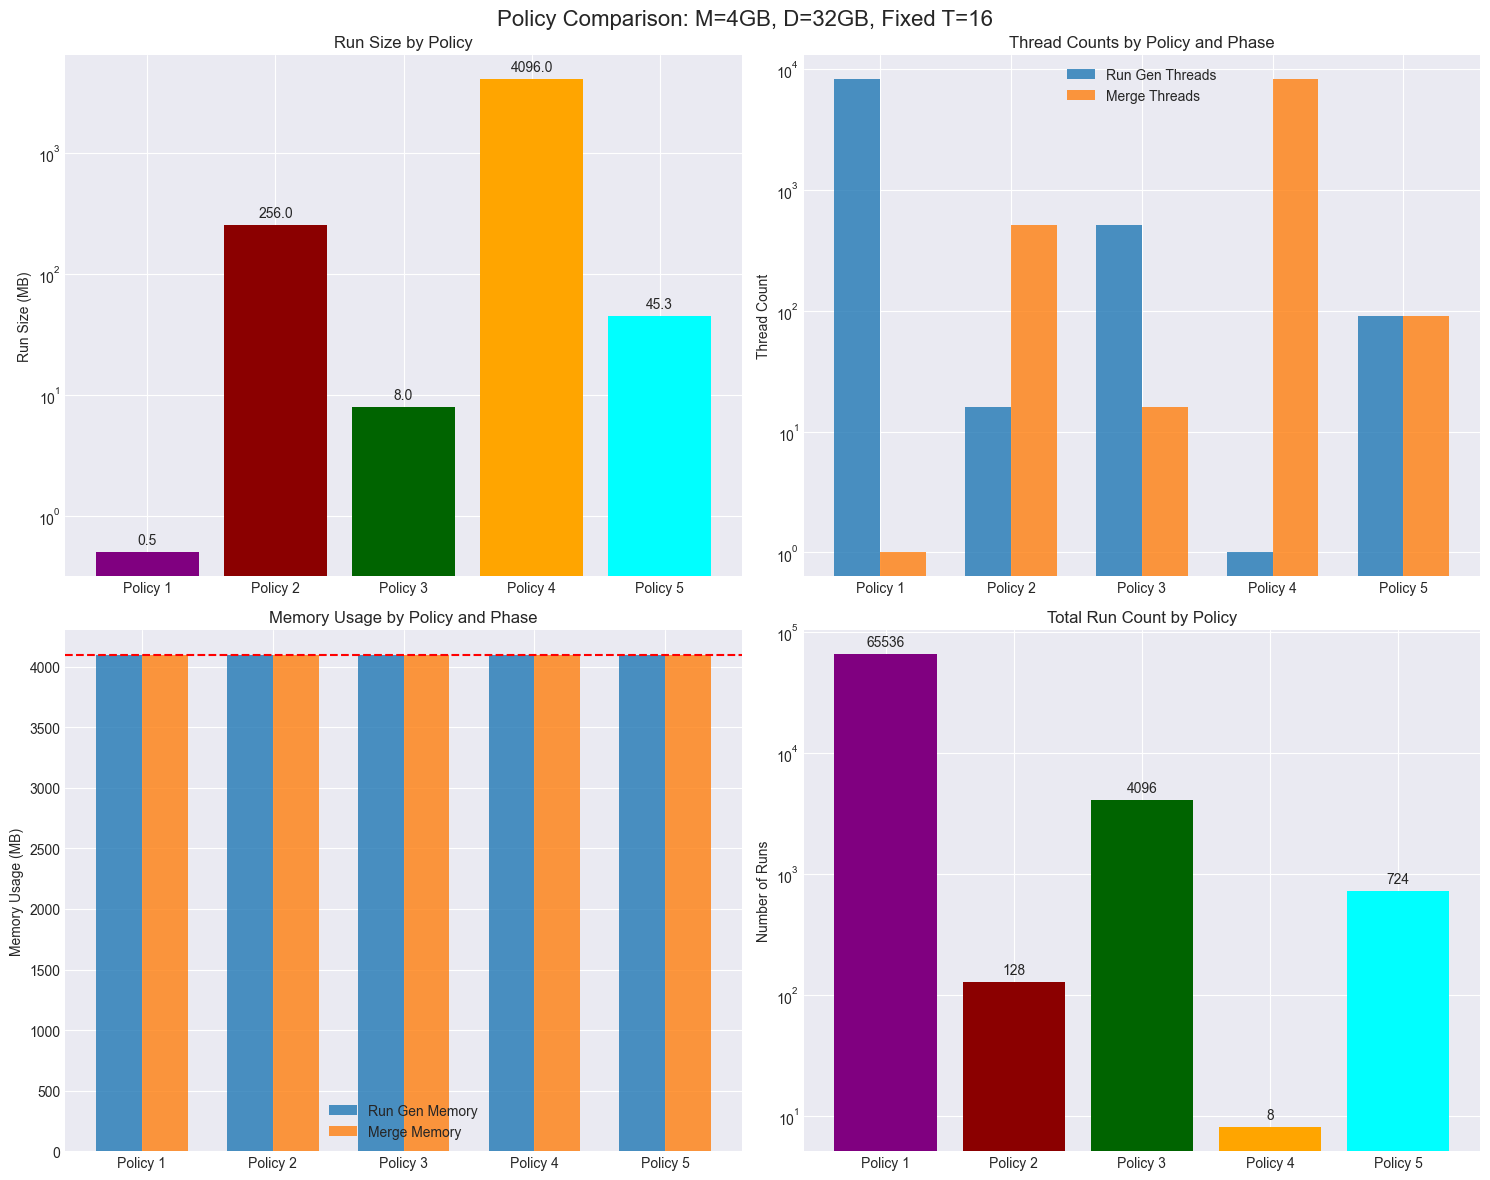

In [8]:
def visualize_policy_comparison(M_GB, D_GB, fixed_threads=32, t_max=128):
    """
    Create visualizations comparing the five policies.
    """
    results = compute_policy_parameters(M_GB, D_GB, fixed_threads, t_max)
    
    # Prepare data for plotting
    policies = ['Policy 1', 'Policy 2', 'Policy 3', 'Policy 4', 'Policy 5']
    run_sizes = [results[f'policy{i+1}']['run_size_mb'] for i in range(5)]
    run_gen_threads = [results[f'policy{i+1}']['run_gen_threads'] for i in range(5)]
    merge_threads = [results[f'policy{i+1}']['merge_threads'] for i in range(5)]
    run_gen_memory = [results[f'policy{i+1}']['run_gen_memory'] for i in range(5)]
    merge_memory = [results[f'policy{i+1}']['merge_memory'] for i in range(5)]
    
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Run Size Comparison
    bars1 = ax1.bar(policies, run_sizes, color=['purple', 'darkred', 'darkgreen', 'orange', 'cyan'])
    ax1.set_ylabel('Run Size (MB)')
    ax1.set_title('Run Size by Policy')
    ax1.set_yscale('log')
    for i, (bar, val) in enumerate(zip(bars1, run_sizes)):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1, 
                f'{val:.1f}', ha='center', va='bottom')
    
    # 2. Thread Count Comparison
    x = np.arange(len(policies))
    width = 0.35
    bars2_1 = ax2.bar(x - width/2, run_gen_threads, width, label='Run Gen Threads', alpha=0.8)
    bars2_2 = ax2.bar(x + width/2, merge_threads, width, label='Merge Threads', alpha=0.8)
    ax2.set_ylabel('Thread Count')
    ax2.set_title('Thread Counts by Policy and Phase')
    ax2.set_xticks(x)
    ax2.set_xticklabels(policies)
    ax2.legend()
    ax2.set_yscale('log')
    
    # 3. Memory Usage Comparison
    bars3_1 = ax3.bar(x - width/2, run_gen_memory, width, label='Run Gen Memory', alpha=0.8)
    bars3_2 = ax3.bar(x + width/2, merge_memory, width, label='Merge Memory', alpha=0.8)
    ax3.set_ylabel('Memory Usage (MB)')
    ax3.set_title('Memory Usage by Policy and Phase')
    ax3.set_xticks(x)
    ax3.set_xticklabels(policies)
    ax3.legend()
    ax3.axhline(y=M_GB*1024, color='red', linestyle='--', label=f'Memory Limit ({M_GB}GB)')
    
    # 4. Run Count and Efficiency
    run_counts = [D_GB*1024/rs for rs in run_sizes]
    ax4.bar(policies, run_counts, color=['purple', 'darkred', 'darkgreen', 'orange', 'cyan'])
    ax4.set_ylabel('Number of Runs')
    ax4.set_title('Total Run Count by Policy')
    ax4.set_yscale('log')
    for i, (bar, val) in enumerate(zip(ax4.patches, run_counts)):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1, 
                f'{val:.0f}', ha='center', va='bottom')
    
    plt.suptitle(f'Policy Comparison: M={M_GB}GB, D={D_GB}GB, Fixed T={fixed_threads}', fontsize=16)
    plt.tight_layout()
    plt.show()


# Visualize the policies
visualize_policy_comparison(M_GB=4, D_GB=32, fixed_threads=16)

## Key Formulas for Each Policy

### Policy 1: TinyRuns_MaxParallelGen_SerialMerge
**Goal**: Create tiny runs to maximize parallelism in run generation, serial merge
- **Run Size**: `RS = D × P × 1 / M = D × P / M`
- **Run Gen Threads**: `T_rg = M / RS` (maximized)
- **Merge Threads**: `T_m = M / ((D / RS) × P)` (approaches 1)

### Policy 2: GenBoundRuns_MaxParallelGen_LimitedParallelMerge
**Goal**: Create generation-bound runs with max parallel generation, limited parallel merge
- **Run Size**: `RS = M / T` (constrained by fixed generation threads)
- **Run Gen Threads**: `T_rg = T` (fixed, uses full memory)
- **Merge Threads**: `T_m = M / ((D / RS) × P)` (limited by fewer runs)

### Policy 3: MergeBoundRuns_LimitedParallelGen_MaxParallelMerge
**Goal**: Create merge-bound runs with limited parallel generation, max parallel merge
- **Run Size**: `RS = D × P × T / M` (constrained by fixed merge threads)
- **Run Gen Threads**: `T_rg = M / RS` (limited by larger runs)
- **Merge Threads**: `T_m = T` (fixed, uses full memory)

### Policy 4: HugeRuns_SerialGen_MaxParallelMerge
**Goal**: Create huge runs with serial generation, maximize merge parallelism
- **Run Size**: `RS = M / 1 = M` (maximized)
- **Run Gen Threads**: `T_rg = 1` (serial)
- **Merge Threads**: `T_m = M / ((D / RS) × P)` (maximized)

### Policy 5: MediumRuns_BalancedParallelism
**Goal**: Balance both phases at the constraint intersection point
- **Thread Count**: `T = min(M / sqrt(D × P), T_max)`
  - This is the crossover point where the two constraints meet
  - Capped at T_max to ensure practical thread counts
- **Run Size**: `RS = M / T`
- **Run Gen Threads**: `T_rg = T` (balanced)
- **Merge Threads**: `T_m = T` (balanced)
- **Note**: This policy ensures both phases require equal memory, achieving optimal balance